In [2]:
import geopandas as gpd
import spatial_aggregation
import xarray as xr
import rasterio as rio
import rioxarray
from shapely.geometry import Point, Polygon
from cartopy import crs as ccrs
import numpy as np


In [45]:
# Raster needs to be created north up.
# https://github.com/perrygeo/python-rasterstats/issues/218#issuecomment-640377751
resolution = 10
dummy_raster = xr.DataArray(
    data=np.random.rand(resolution, resolution),
    coords={"lat": np.linspace(11, 10, resolution), "lon": np.linspace(0, 1, resolution)},
    dims=["lat", "lon"],
)
dummy_raster = dummy_raster.rio.write_crs("EPSG:4326")
dummy_raster = dummy_raster.rio.set_spatial_dims("lon", "lat")


def get_random_point(xlim: tuple, ylim: tuple):
    return Point(np.random.rand() * (xlim[1] - xlim[0]) + xlim[0],
                 np.random.rand() * (ylim[1] - ylim[0]) + ylim[0])


def get_random_square(xlim, ylim, size):
    point = get_random_point(xlim, ylim)
    x, y = point.x, point.y
    return Polygon([(x, y), (x + size, y), (x + size, y + size), (x, y + size)])

n_square = 4
dummy_polygons = gpd.GeoDataFrame(
    {'id': range(n_square),
     'geometry': [
            get_random_square((0, 1), (10, 11), 0.2) for _ in range(n_square)
     ]},
    crs="EPSG:4326"
)
def get_square_segmentation(xlim, ylim, resolution):
    size = (xlim[1] - xlim[0]) / resolution
    polygons = []
    for i in range(resolution):
        for j in range(resolution):
            x, y = xlim[0] + i * size, ylim[0] + j * size
            polygons.append(Polygon([(x, y), (x + size, y), (x + size, y + size), (x, y + size)]))
    return polygons

square_segmentation = gpd.GeoDataFrame(
        {'id': range(resolution ** 2),
         'geometry': get_square_segmentation((0, 1), (10, 11), 10)
        },
        crs="EPSG:4326"
    )

dummy_polygons = gpd.GeoDataFrame(
    {'id': range(n_square),
     'geometry': [
            get_random_square((0, 1), (10, 11), 0.2) for _ in range(n_square)
     ]},
    crs="EPSG:4326"
)



n_points = 10
dummy_points = gpd.GeoDataFrame(
    {'id': range(n_points),
     'data': np.random.rand(n_points),
     'geometry': [
            get_random_point((0, 1), (10, 11)) for _ in range(n_points)
         ], 
    },
    crs="EPSG:4326"
).set_index('id')

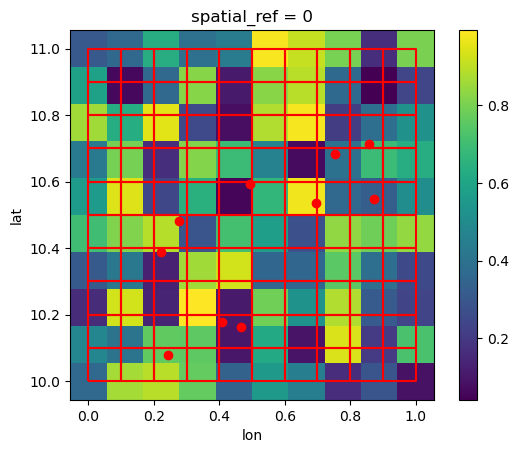

In [46]:
# plot
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(111)
dummy_raster.plot(ax=ax)
square_segmentation.boundary.plot(ax=ax, color="red")
dummy_points.plot(ax=ax, color="red")
plt.show()


In [47]:
from rasterstats import zonal_stats

def aggregate_raster_to_polygon(
        raster_data: xr.Dataset|str,
        polygons: gpd.GeoSeries|gpd.GeoDataFrame,
        transform: None
) -> gpd.GeoDataFrame:
    r"""
    Aggregate raster data with spatial units and aggregate the data.
    """
    # Aggregate raster data to spatial units
    if isinstance(polygons, gpd.GeoSeries):
        aggregated_data = polygons.to_frame()
    elif isinstance(polygons, gpd.GeoDataFrame):
        aggregated_data = polygons.copy()
    else:
        raise ValueError("`polygons` should be either a GeoSeries or a GeoDataFrame.")
    if isinstance(raster_data, str):
        raise NotImplementedError("Not implemented yet.")

    if hasattr(raster_data, "name"):
        name_variable = raster_data.name
    else:
        name_variable = "value"
    print(aggregated_data)
    a = zonal_stats(polygons.geometry, raster_data) #, affine=transform, stats=['mean', 'sum', 'count'])
    print(a)
    aggregated_data[name_variable] = a
    return aggregated_data


def aggregate_point_to_polygon(points: gpd.GeoDataFrame, polygons: gpd.GeoSeries|gpd.GeoDataFrame, aggfunc='sum'):
    if isinstance(polygons, gpd.GeoSeries):
        _polygons = polygons.to_frame()
    elif isinstance(polygons, gpd.GeoDataFrame):
        _polygons = polygons
    else:
        raise ValueError("`polygons` should be either a GeoSeries or a GeoDataFrame.")

    joined_data = gpd.sjoin(points, _polygons, how="inner", op="within").drop(columns="geometry")

    aggregated_data = joined_data.groupby("index_right").agg(aggfunc)

    result = _polygons.join(aggregated_data)

    return result


def aggregate_polygon_to_polygon(input_polygons:gpd.GeoDataFrame, target_polygons: gpd.GeoSeries|gpd.GeoDataFrame):
    """Based on the assumption that the data is equally distributed accross the area"""
    return 

In [48]:
dummy_raster.rio.set_spatial_dims("lon", "lat").rio.to_raster("dummy_raster.tif", compress='LZW')


In [55]:

agg_raster_poly = zonal_stats(
    square_segmentation, dummy_raster.values, affine=dummy_raster.rio.transform(), stats='sum'
)
agg_raster_poly

[{'sum': None},
 {'sum': None},
 {'sum': None},
 {'sum': None},
 {'sum': None},
 {'sum': None},
 {'sum': None},
 {'sum': None},
 {'sum': None},
 {'sum': None},
 {'sum': 0.8656958665145055},
 {'sum': 0.4065003122995391},
 {'sum': 0.9292824749891032},
 {'sum': 0.42416357659195036},
 {'sum': 0.812942174381277},
 {'sum': 0.9453064266016763},
 {'sum': 0.7959198510256152},
 {'sum': 0.630631315675768},
 {'sum': 0.061237760234167715},
 {'sum': 0.3596964315659976},
 {'sum': 0.890262826517744},
 {'sum': 0.7611852779213033},
 {'sum': 0.13597995359429804},
 {'sum': 0.13089139068384203},
 {'sum': 0.8864048728328501},
 {'sum': 0.24412388987424505},
 {'sum': 0.16558900808510768},
 {'sum': 0.9520013796213027},
 {'sum': 0.35951486293395474},
 {'sum': 0.6366746329588154},
 {'sum': 0.7645008088360163},
 {'sum': 0.7575789251706626},
 {'sum': 0.9936893244046505},
 {'sum': 0.8593733836010086},
 {'sum': 0.29282282304004736},
 {'sum': 0.6457228607678438},
 {'sum': 0.8154167585374917},
 {'sum': 0.2550326967337

In [81]:
agg_point_poly = aggregate_point_to_polygon(
    dummy_points, square_segmentation.geometry, aggfunc={"data": "mean"}
)

agg_point_poly.loc[~agg_point_poly.data.isna()]

/home/jlauner/mambaforge/envs/spatial-disaggregation/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)


,geometry,data
4,"POLYGON ((0.00000 10.40000, 0.10000 10.40000, ...",0.042724
24,"POLYGON ((0.20000 10.40000, 0.30000 10.40000, ...",0.188292
36,"POLYGON ((0.30000 10.60000, 0.40000 10.60000, ...",0.762794
50,"POLYGON ((0.50000 10.00000, 0.60000 10.00000, ...",0.909976
51,"POLYGON ((0.50000 10.10000, 0.60000 10.10000, ...",0.506623
54,"POLYGON ((0.50000 10.40000, 0.60000 10.40000, ...",0.501532
60,"POLYGON ((0.60000 10.00000, 0.70000 10.00000, ...",0.452282
81,"POLYGON ((0.80000 10.10000, 0.90000 10.10000, ...",0.279992
83,"POLYGON ((0.80000 10.30000, 0.90000 10.30000, ...",0.807329
